# **0. Importación de <ins>librerías</ins> y <ins>carga de archivos</ins>**

In [1]:
## IMPORTACIÓN DE LIBRERÍAS

import pandas as pd # Pandas
import matplotlib.pyplot as plt # Matplorlib
import matplotlib.colors as mcolors # Matplorlib
import matplotlib.dates as mdates
#from dateutil.relativedelta import relativedelta # Dates
#import seaborn as sns #Seaborn
import numpy as np #Numpy
from matplotlib.colors import LinearSegmentedColormap #Paleta de colores
import pycaret
from pycaret.regression import *
from prophet import Prophet
from pycaret.regression import save_model
from pycaret.regression import load_model
# Desactivamos Warnings
#import warnings
#warnings.filterwarnings('ignore')
from pycaret.regression import setup, compare_models
from sklearn.model_selection import TimeSeriesSplit


# MODELO

In [2]:
df_completo = pd.read_csv('df_completo.csv')

In [3]:
df_completo.head()

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion,Año,Mes,Dia_del_Mes,Semana_del_año
0,5201,2021-05-02,600790,7.0,1393.0,199.0,Domingo,1,31064,216,1,No,2021,5,2,17
1,5201,2021-05-02,600793,2.0,390.0,195.0,Domingo,1,31064,216,1,No,2021,5,2,17
2,5201,2021-05-02,600794,7.0,2023.0,289.0,Domingo,1,31064,216,1,No,2021,5,2,17
3,5201,2021-05-02,605089,1.0,399.0,399.0,Domingo,1,22010,216,1,No,2021,5,2,17
4,5201,2021-05-02,605548,1.0,305.0,305.0,Domingo,1,31062,216,1,No,2021,5,2,17


In [4]:
#Corroboramos que Feha de venta este en formato "datatime"
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119029 entries, 0 to 119028
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID_tienda         119029 non-null  int64  
 1   Fecha_venta       119029 non-null  object 
 2   ID_producto       119029 non-null  int64  
 3   Cant_vendidas     119029 non-null  float64
 4   Facturacion       119029 non-null  float64
 5   Precio_unidad     119029 non-null  float64
 6   Dia_sem           119029 non-null  object 
 7   Status            119029 non-null  int64  
 8   ID_proveedor      119029 non-null  int64  
 9   Categoria         119029 non-null  int64  
 10  Clasif_proveedor  119029 non-null  int64  
 11  Promocion         119029 non-null  object 
 12  Año               119029 non-null  int64  
 13  Mes               119029 non-null  int64  
 14  Dia_del_Mes       119029 non-null  int64  
 15  Semana_del_año    119029 non-null  int64  
dtypes: float64(3), int64

In [5]:
# Convertir columnas  de int64 a float
df_completo['Cant_vendidas'] = df_completo['Cant_vendidas'].astype(float)


In [6]:
# Verificar si hay valores NaN
print(df_completo.isna().any())

ID_tienda           False
Fecha_venta         False
ID_producto         False
Cant_vendidas       False
Facturacion         False
Precio_unidad       False
Dia_sem             False
Status              False
ID_proveedor        False
Categoria           False
Clasif_proveedor    False
Promocion           False
Año                 False
Mes                 False
Dia_del_Mes         False
Semana_del_año      False
dtype: bool


In [7]:
#Dejamos solo un valor después de la coma en la variable 'Precio_unidad'
df_completo['Precio_unidad'] = df_completo['Precio_unidad'].round(1)

In [8]:
# Detectamos filas en la columna 'Precio_unidad' que contienen valores infinitos
inf_rows = df_completo[df_completo['Precio_unidad'].isin([np.inf, -np.inf])]

In [9]:
# Reemplazar valores infinitos por NaN
df_completo['Precio_unidad'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar filas con NaN en 'Precio_unidad'
df_completo.dropna(subset=['Precio_unidad'], inplace=True)

# Verificar cuántas filas quedan después de eliminar los valores infinitos
print("Número de filas después de eliminar valores infinitos:", df_completo.shape[0])

Número de filas después de eliminar valores infinitos: 119029


In [10]:
# Convertir la columna 'Fecha_venta' a datetime
df_completo['Fecha_venta'] = pd.to_datetime(df_completo['Fecha_venta'])

In [11]:
#Corroboramos que Feha de venta este en formato "datatime"
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119029 entries, 0 to 119028
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID_tienda         119029 non-null  int64         
 1   Fecha_venta       119029 non-null  datetime64[ns]
 2   ID_producto       119029 non-null  int64         
 3   Cant_vendidas     119029 non-null  float64       
 4   Facturacion       119029 non-null  float64       
 5   Precio_unidad     119029 non-null  float64       
 6   Dia_sem           119029 non-null  object        
 7   Status            119029 non-null  int64         
 8   ID_proveedor      119029 non-null  int64         
 9   Categoria         119029 non-null  int64         
 10  Clasif_proveedor  119029 non-null  int64         
 11  Promocion         119029 non-null  object        
 12  Año               119029 non-null  int64         
 13  Mes               119029 non-null  int64         
 14  Dia_

In [12]:
#Corroboramos que Feha de venta este en formato "datatime"
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119029 entries, 0 to 119028
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID_tienda         119029 non-null  int64         
 1   Fecha_venta       119029 non-null  datetime64[ns]
 2   ID_producto       119029 non-null  int64         
 3   Cant_vendidas     119029 non-null  float64       
 4   Facturacion       119029 non-null  float64       
 5   Precio_unidad     119029 non-null  float64       
 6   Dia_sem           119029 non-null  object        
 7   Status            119029 non-null  int64         
 8   ID_proveedor      119029 non-null  int64         
 9   Categoria         119029 non-null  int64         
 10  Clasif_proveedor  119029 non-null  int64         
 11  Promocion         119029 non-null  object        
 12  Año               119029 non-null  int64         
 13  Mes               119029 non-null  int64         
 14  Dia_

In [13]:
# Incluir características de retraso y estadísticas rodantes
df_completo['Lag_1'] = df_completo['Cant_vendidas'].shift(1)
df_completo['Rolling_Mean_7'] = df_completo['Cant_vendidas'].rolling(window=7).mean()
df_completo['Rolling_Std_7'] = df_completo['Cant_vendidas'].rolling(window=7).std()

In [14]:
# Eliminar filas con NaN debido a las características de retraso
df_completo.dropna(inplace=True)

In [15]:
#Corroboramos que Feha de venta este en formato "datatime"
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119023 entries, 6 to 119028
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID_tienda         119023 non-null  int64         
 1   Fecha_venta       119023 non-null  datetime64[ns]
 2   ID_producto       119023 non-null  int64         
 3   Cant_vendidas     119023 non-null  float64       
 4   Facturacion       119023 non-null  float64       
 5   Precio_unidad     119023 non-null  float64       
 6   Dia_sem           119023 non-null  object        
 7   Status            119023 non-null  int64         
 8   ID_proveedor      119023 non-null  int64         
 9   Categoria         119023 non-null  int64         
 10  Clasif_proveedor  119023 non-null  int64         
 11  Promocion         119023 non-null  object        
 12  Año               119023 non-null  int64         
 13  Mes               119023 non-null  int64         
 14  Dia_del_M

In [18]:
#Configuración de PyCaret
#Carga de datos en un DataFrame de pandas y configuramos entorno de PyCaret. 
#Se saca Date, pues ni pycaret ni los modelos propuestos estan optimizados para trabajar con fechas,
#Series Temporales, por lo tanto a priori es retirada.


reg = setup(data=df_completo, target='Cant_vendidas', session_id=123,
            ignore_features=['Fecha_venta', 'Status', 'ID_tienda', 'ID_proveedor', 'Facturacion', 'Clasif_proveedor', 'Semana_del_año'],
            categorical_features=['ID_producto', 'Categoria', 'Dia_sem', 'Promocion', 'Mes', 'Dia_del_Mes'],
            numeric_features=['Lag_1', 'Rolling_Mean_7', 'Rolling_Std_7', 'Precio_unidad'],
            normalize=True, transformation=True,
            transform_target=True, 
            fold=5)  # Usando validación cruzada temporal de 5 pliegues
          

,Description,Value
0,Session id,123
1,Target,Cant_vendidas
2,Target type,Regression
3,Original data shape,"(119023, 19)"
4,Transformed data shape,"(119023, 29)"
5,Transformed train set shape,"(83316, 29)"
6,Transformed test set shape,"(35707, 29)"
7,Ignore features,7
8,Numeric features,4
9,Categorical features,6


In [19]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,2.6861,84.2323,9.1302,0.3773,0.6106,0.7661,0.4780
rf,Random Forest Regressor,2.4496,107.0464,10.3249,0.2088,0.5001,0.4103,4.4560
et,Extra Trees Regressor,2.4580,108.2394,10.3799,0.2008,0.5071,0.4194,3.5060
knn,K Neighbors Regressor,2.5818,111.9372,10.5532,0.1742,0.5416,0.4927,1.3000
omp,Orthogonal Matching Pursuit,2.8389,133.1652,11.5178,0.0153,0.6180,0.4591,0.3940
ada,AdaBoost Regressor,2.9010,135.2984,11.6103,-0.0007,0.6449,0.4673,0.6940
par,Passive Aggressive Regressor,2.4243,114.5395,9.5642,-0.0114,0.5382,0.4412,0.4060
lasso,Lasso Regression,3.0981,141.4638,11.8732,-0.0467,0.7563,0.5273,0.9220
en,Elastic Net,3.0981,141.4638,11.8732,-0.0467,0.7563,0.5273,0.4020
llar,Lasso Least Angle Regression,3.0981,141.4638,11.8732,-0.0467,0.7563,0.5273,0.3840


In [20]:
best_model

DecisionTreeRegressor(random_state=123)

In [ ]:
#Afinación del Modelo. Se evaluan  automaticamente los Hipermarametros a utilizar.
#tuned_model = tune_model(best_model)

In [21]:
# Ajustar modelo con regularización, por ejemplo, Ridge Regression

tuned_ridge = tune_model(best_model, optimize='R2')


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.5764,124.2851,11.1483,0.1605,0.5188,0.4382
1,2.3487,94.4011,9.7160,0.1508,0.5096,0.4322
2,2.6699,126.7330,11.2576,0.1420,0.5336,0.4296
3,2.5022,100.2322,10.0116,0.1725,0.5155,0.4265
4,2.5666,123.6212,11.1185,0.1637,0.5182,0.4293
Mean,2.5328,113.8546,10.6504,0.1579,0.5191,0.4311
Std,0.1065,13.6678,0.6507,0.0106,0.0079,0.0040


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [22]:
final_model = finalize_model(tuned_ridge)
predictions = predict_model(final_model, data=df_completo)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0000,0.0000,0.0019,1.0000,0.0000,0.0000


In [ ]:
evaluate_model(tuned_model2)

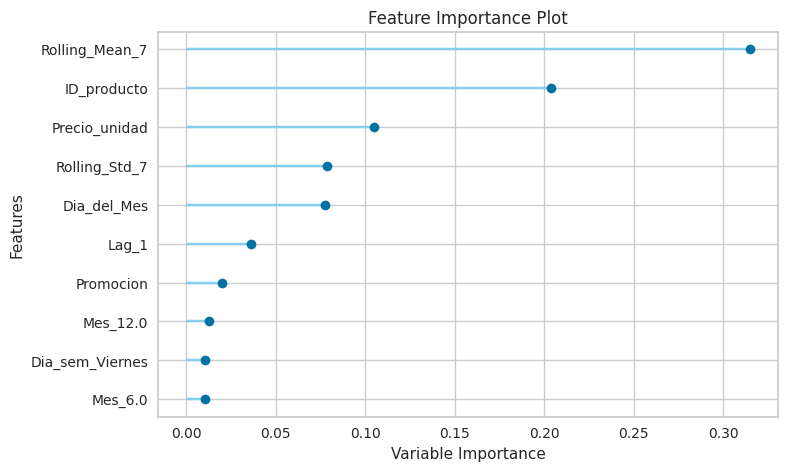

In [23]:
plot_model(tuned_ridge, plot='feature')


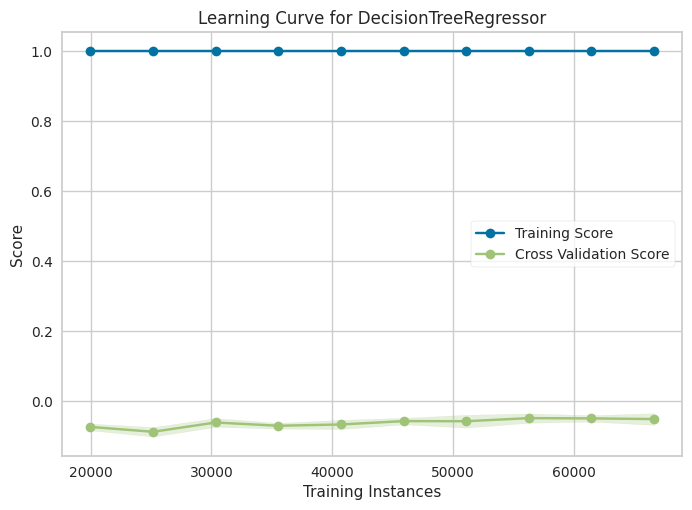

In [24]:
plot_model(tuned_ridge, plot='learning')

In [ ]:
predictions = predict_model(tuned_model2, data=df_completo)

In [ ]:
predictions

In [ ]:
predictions.to_csv('predictions.csv', index=False)

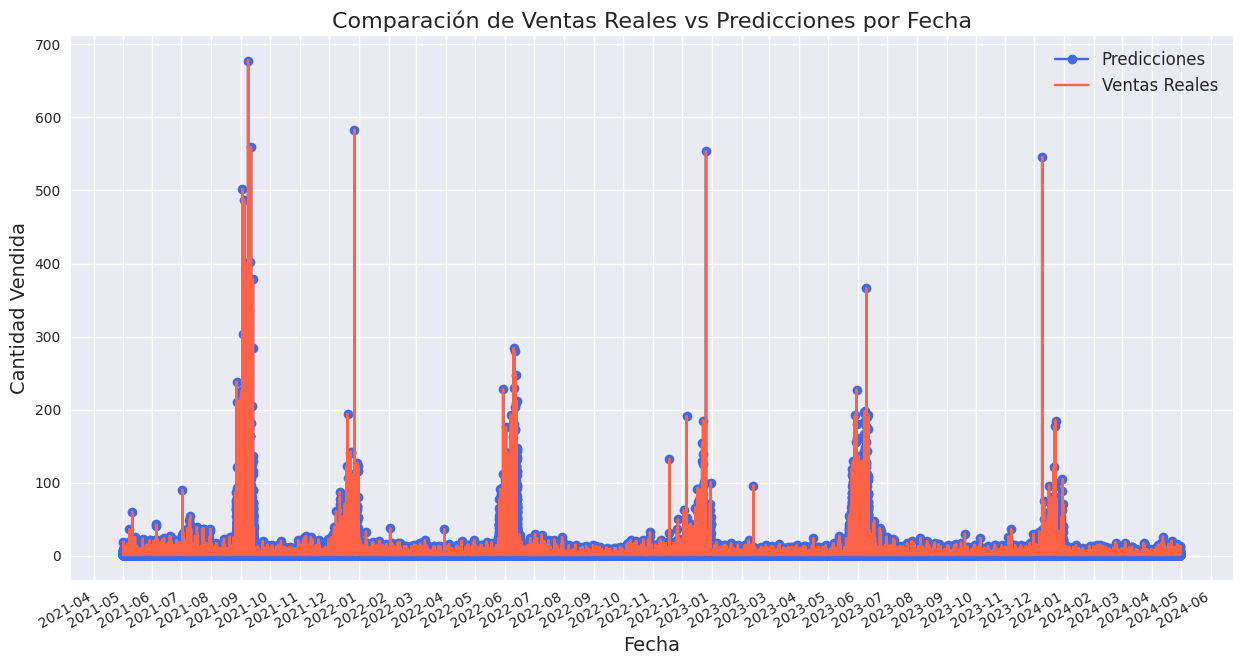

In [25]:
plt.figure(figsize=(15, 8))  # Tamaño del gráfico
plt.style.use('seaborn-darkgrid')  # Estilo de fondo de cuadrícula con tema oscuro

# Gráfico de predicciones
plt.plot(predictions['Fecha_venta'], predictions['prediction_label'], label='Predicciones', marker='o', linestyle='-', color='royalblue')

# Gráfico de ventas reales
plt.plot(df_completo['Fecha_venta'], df_completo['Cant_vendidas'], label='Ventas Reales', marker='x', linestyle='-', color='tomato')

# Configuración de los formatos de fecha en el eje X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Intervalo mensual
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato año-mes

plt.title('Comparación de Ventas Reales vs Predicciones por Fecha', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Mejorar la rotación y alineación de las etiquetas de fecha
plt.gcf().autofmt_xdate()

plt.savefig('high_quality_chart.png', dpi=300)  # Guardar como imagen de alta calidad
plt.show()


In [ ]:
# Gráfico de aprendizaje para evaluar el overfitting
plot_model(tuned_model, plot='learning')


In [ ]:
# Interpretación del modelo para Random Forest
interpret_model(tuned_model)


In [ ]:
save_model(tuned_model, 'modelo_final')
